In [1]:
%load_ext autoreload
%autoreload 2
import barcoderegression
import pickle
import numpy as np
import matplotlib.pylab as plt
import scipy as sp
import scipy.ndimage
import tqdm.notebook
import numpy.random as npr
import ipywidgets
import skimage
import skimage.feature

from barcoderegression.plotting import AnimAcross

%matplotlib inline

def rbyc(A):
    mx=A.max()
    with AnimAcross(columns=A.shape[-1]) as a:
        for c in range(A.shape[-2]):
            for r in range(A.shape[-1]):
                ~a
                mappable=plt.imshow(A[:,:,c,r],vmin=0,vmax=mx)
                a.cb(mappable)
                plt.axis('off')
    
def rbycs(*args):
    def go(i):
        rbyc(args[i])
    ipywidgets.interact(go,i=list(range(len(args))))
    
def frames(model):
    frame_loadings=model.frame_loadings()
    with AnimAcross() as a:
        for j in range(model.J):
            a(j)
            a.cb(plt.imshow(frame_loadings[:,:,j]))
            plt.axis('off')

def spatials(model,spdims,blurred=True):
    F = model.F_scaled(blurred=blurred)

    with AnimAcross() as a:
        for j in range(model.J):
            a(j)
            a.cb(plt.imshow(F[:,j].reshape(spdims)))

# simulate data

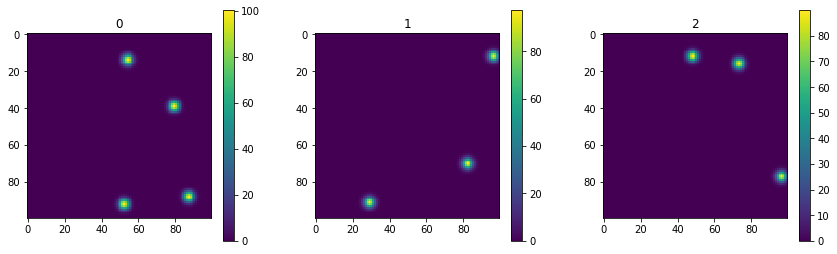

In [24]:
spdims=(100,100)
R=6
C=4
J=3

model,X,X_without_noise = barcoderegression.simulations.simulation(
    R=R,C=C,J=J,spatial_dims=spdims,
    num_spots=10,blursize=[2,2],noise=3,rho=npr.rand(C),
    anoise=.01,bnoise=.01,
    lam=0.1,varphinoise=5)

spatials(model,spdims)

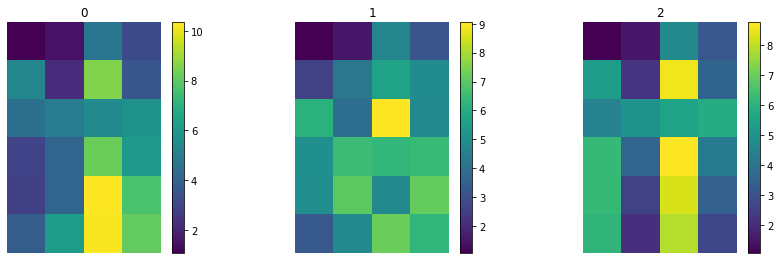

In [25]:
frames(model)

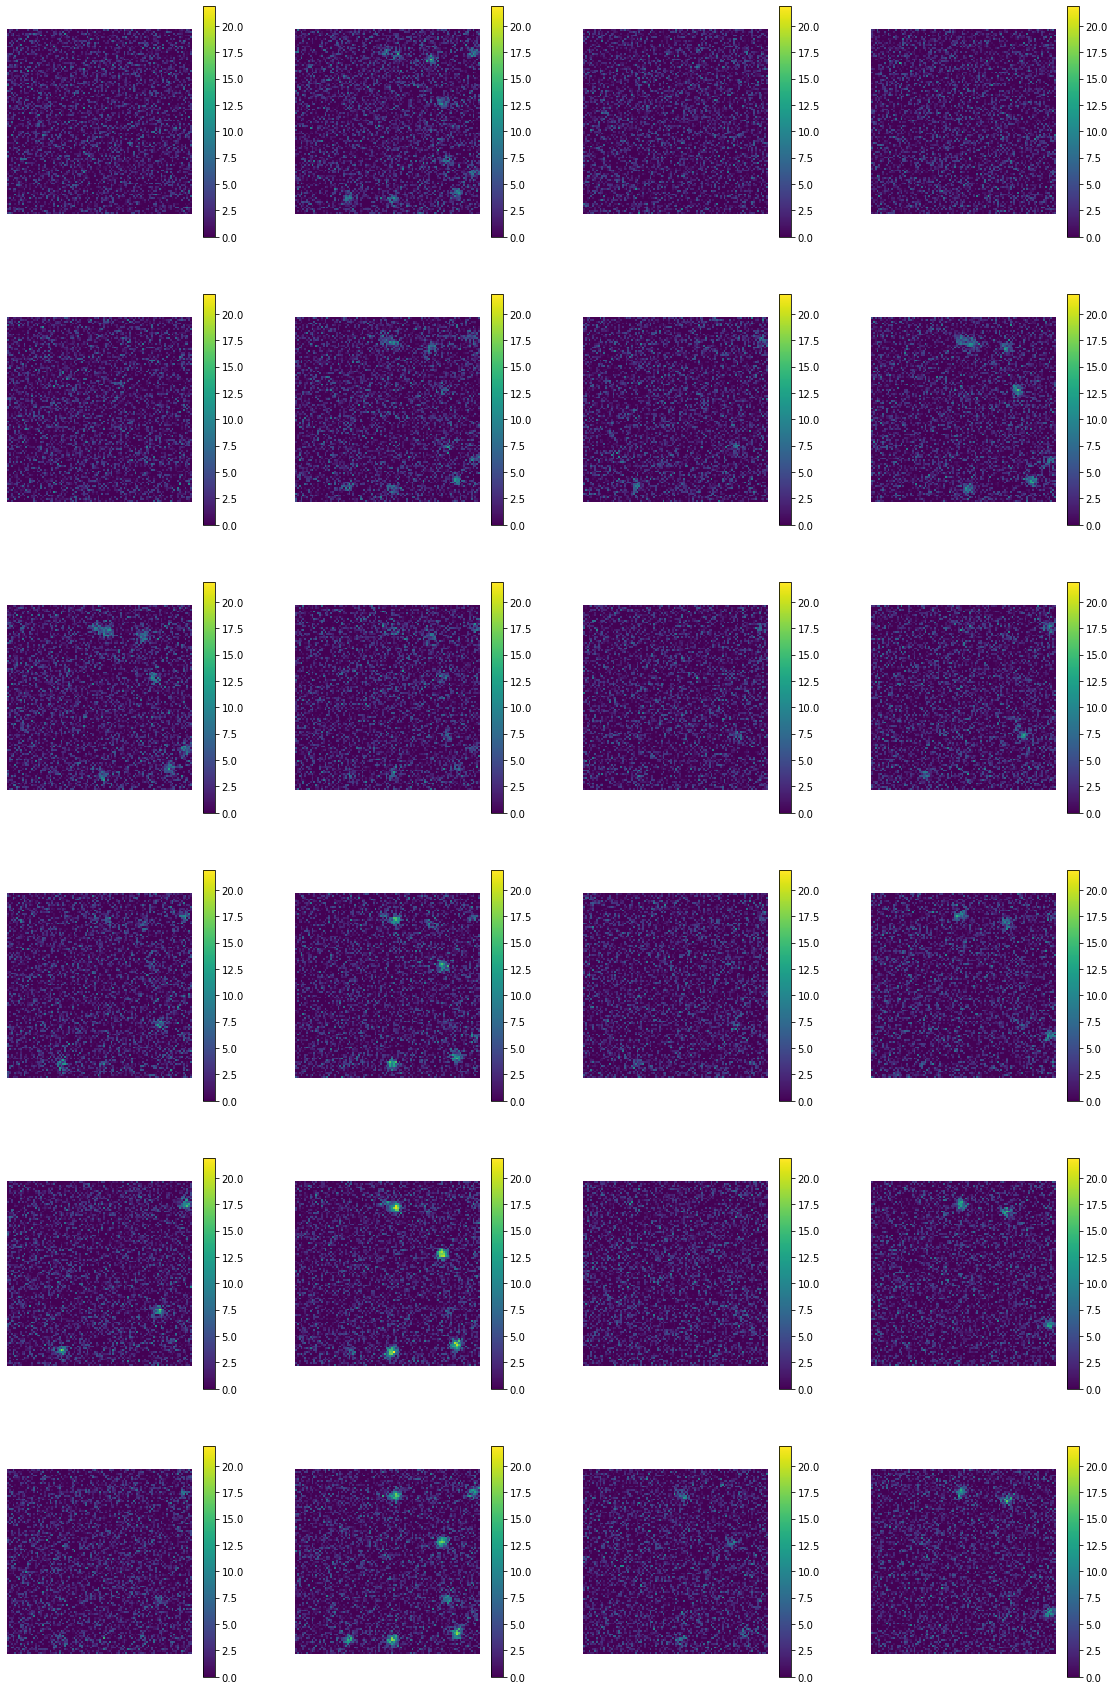

In [26]:
rbyc(X)

In [27]:
Xrav=X.reshape((-1,R,C))
lossinfo=model.loss(Xrav)
bestloss=lossinfo['loss']
print('final reconstruction loss per obs',lossinfo['reconstruction']/model.nobs)
print('final L1 loss perobs',model.lam*lossinfo['l1']/model.nobs)
print('true loss perobs',lossinfo['loss']) 

final reconstruction loss per obs 4.644080910980447
final L1 loss perobs 0.009996715679687634
true loss perobs 4.654077626660135


# try to learn loadings


we never went the wrong way!
final reconstruction loss per obs 4.372705457239387
final L1 loss perobs 0.008690894229754031
final loss 4.3813963514691405


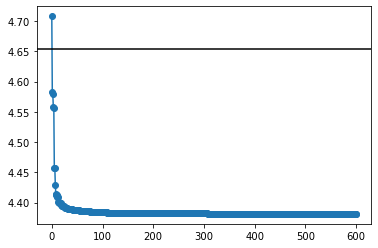

In [41]:
# model2=model.copy()
model2=barcoderegression.parameters.Model(model.B,model.K,M=model.M,lam=model.lam)

trainer=barcoderegression.training.Trainer(X,model2)
for i in tqdm.notebook.tqdm(range(100)):
    trainer.update(nms=['F','varphi','alpha','rho','a','b',])

overall_losses=[x['loss'] for x in trainer.losses]
worst=np.diff(overall_losses).max()
if worst<=0:
    print("we never went the wrong way!")
else:
    print("we went wrong way",worst)
plt.plot(overall_losses,'-o')
plt.axhline(bestloss,color='black')

lossinfo=model2.loss(Xrav)
print('final reconstruction loss per obs',lossinfo['reconstruction']/model2.nobs)
print('final L1 loss perobs',model2.lam*lossinfo['l1']/model2.nobs)
print('final loss',lossinfo['loss'])

bads=[x for x in trainer.losses if x['improvement']<0]
for b in bads:
    print(b['action'],b['reconstruction'],b['improvement'])

In [42]:
bads=[x for x in trainer.losses if x['improvement']<0]
for b in bads:
    print(b['action'],b['reconstruction'],b['improvement'])

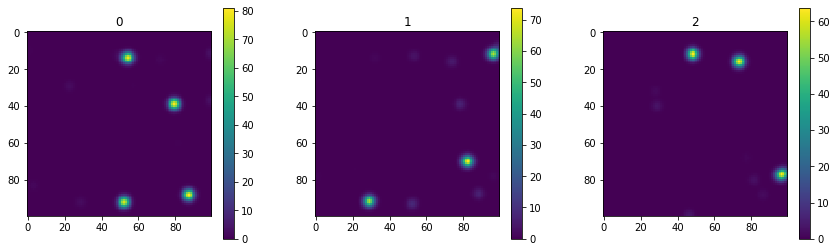

In [43]:
# we learned:
spatials(model2,spdims,blurred=True)

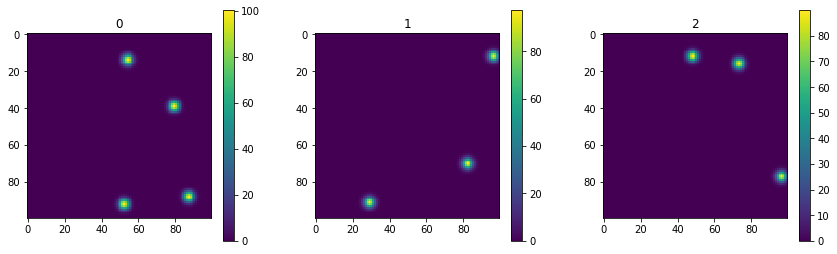

In [44]:
# truth is:
spatials(model,spdims,blurred=True)

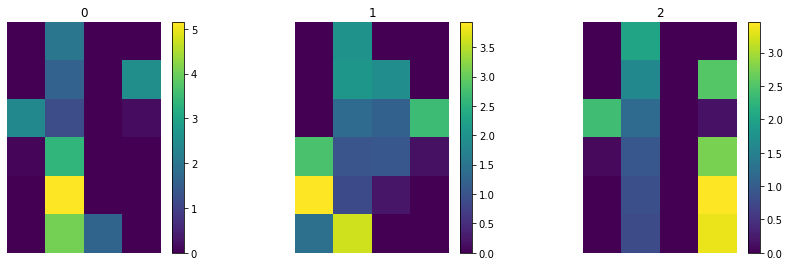

In [45]:
# we learned
frames(model2)

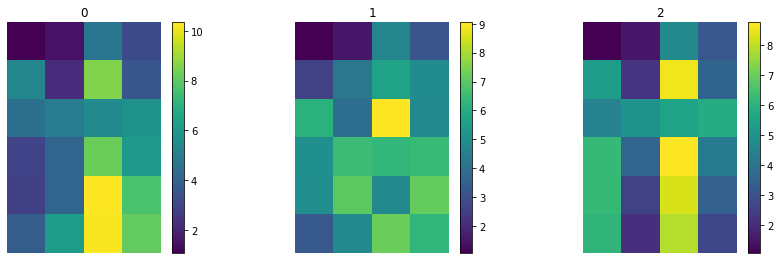

In [46]:
# truth is
frames(model)

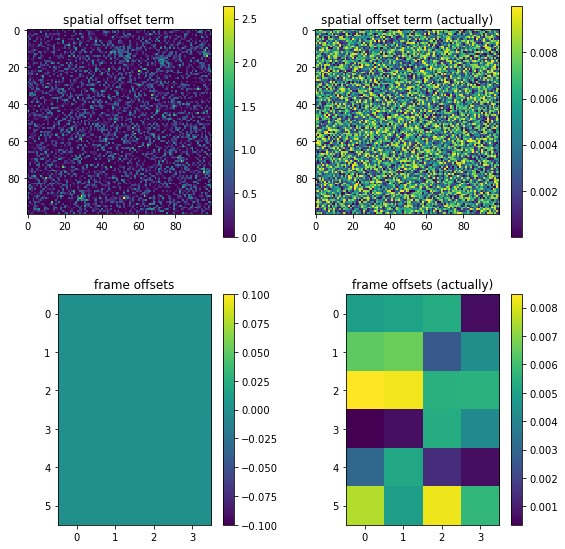

In [47]:
with AnimAcross(columns=2) as a:
    a("spatial offset term")
    a.cb(plt.imshow(model2.a.reshape(spdims)))
    
    a("spatial offset term (actually)")
    a.cb(plt.imshow(model.a.reshape(spdims)))
    
    a('frame offsets')
    a.cb(plt.imshow(model2.b))
    
    a('frame offsets (actually)')
    a.cb(plt.imshow(model.b))

In [35]:
recon=model2.reconstruction().reshape(X.shape)
rbycs(recon,X)

interactive(children=(Dropdown(description='i', options=(0, 1), value=0), Output()), _dom_classes=('widget-int…

# try on real data

In [89]:
with open("example.pkl",'rb') as f:
    example=pickle.load(f)
    X=example['data'].transpose([2,3,0,1])
    B=example['barcode'].astype(np.bool)
    R=X.shape[-2]
    C=X.shape[-1]
    Xrav=X.reshape((-1,R,C))


we never went the wrong way!
final perpix reconstruction loss 0.16146494459879754
final perpix L1 loss 0.10163778672537503
final loss 0.26310273132417256


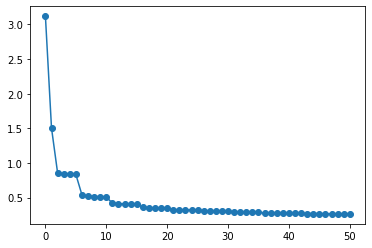

In [100]:
M=np.prod(X.shape[:-2])
model2=barcoderegression.parameters.Model(
    B,
    barcoderegression.blurkernels.ContiguousBlur(X.shape[:2],[1,1]),
    M=M,
    rho=np.ones(C)*.05,
    lam=.1)

trainer=barcoderegression.training.Trainer(X,model2)
for i in tqdm.notebook.tqdm(range(10)):
    trainer.update(nms=['F','alpha','b','a','rho'])

overall_losses=[x['loss'] for x in trainer.losses]
worst=np.diff(overall_losses).max()
if worst<=0:
    print("we never went the wrong way!")
else:
    print("we went wrong way",worst)
plt.plot(overall_losses,'-o')

lossinfo=model2.loss(Xrav)
print('final perpix reconstruction loss',lossinfo['reconstruction']/(R*C*M))
print('final perpix L1 loss',model2.lam*lossinfo['l1']/(R*C*M))
print('final loss',lossinfo['loss'])

In [102]:
bads=[x for x in trainer.losses if x['improvement']<0]
for b in bads:
    print(b['action'],b['reconstruction'],b['improvement'])

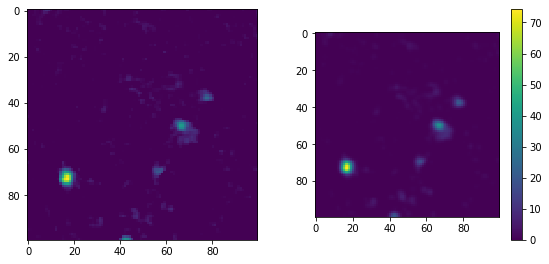

In [103]:
with AnimAcross() as a:
    ~a
    F=model2.F_scaled(blurred=False)
    plt.imshow(F[:,23].reshape(X.shape[:2]))
    ~a
    F=model2.F_scaled(blurred=True)
    a.cb(plt.imshow(F[:,23].reshape(X.shape[:2])))

In [122]:
F=model2.F_scaled(blurred=False).reshape(X.shape[:2]+(model2.J,))
def go(idx,thresh):
    plt.imshow(F[:,:,idx])
    peaks=skimage.feature.peak_local_max(F[:,:,idx],threshold_abs=thresh)
    plt.colorbar()
    plt.axis("off")
    plt.scatter(peaks[:,1],peaks[:,0],marker='x',color='red')
    plt.title(f"{len(peaks)} peaks")
    
ipywidgets.interact(go,idx=list(range(model2.J)),thresh=(1,70))

interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

<function __main__.go(idx, thresh)>

(array([60]),)

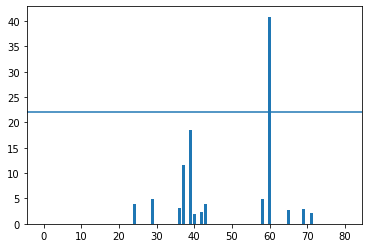

In [197]:
THRESH=22
idx=23
allpeaks=[]
for idx in range(model2.J):
    peaks=skimage.feature.peak_local_max(F[:,:,idx],threshold_abs=THRESH)
    peaks=np.c_[np.ones(len(peaks))*idx,peaks]
    allpeaks.append(peaks)
allpeaks=np.concatenate(allpeaks,axis=0)

# good=np.where(model2.B[1,3]*model2.B[2,1])[0]
# allpeaks=[x for x in allpeaks if (x[0] in good)]

# good=np.where(model2.B[0,2]*model2.B[1,0]*model2.B[2,3])[0]
# allpeaks=[x for x in allpeaks if (x[0] in good)]

allpeaks=[x for x in allpeaks if (x[0]==60)]

print(allpeaks)

[array([60., 89., 44.]), array([60., 83., 57.]), array([60., 76., 29.]), array([60., 74., 41.]), array([60., 69., 71.]), array([60., 65., 37.]), array([60., 60., 42.]), array([60., 58., 69.]), array([60., 37., 72.]), array([60., 35., 48.]), array([60., 34., 54.]), array([60., 31., 41.])]


In [198]:
F=model2.F_scaled(blurred=False).reshape(X.shape[:2]+(model2.J,))
def go(idx,radius):
    gene,x,y=allpeaks[idx]
    gene=int(gene)
    st=np.max([[0,0],[x-radius,y-radius]],axis=0)
    en=np.min([np.r_[X.shape[:2]],[x+radius+1,y+radius+1]],axis=0)
    sl=tuple([slice(int(a),int(b)) for (a,b) in zip(st,en)])
    with AnimAcross(columns=model2.C,sz=2) as a:
        for r in range(model2.R):
            for c in range(model2.C):
                if r==0 and c==0:
                    a(f'{x},{y}')
                else:
                    ~a
                plt.imshow(X[sl+(r,c)],vmin=0,vmax=X[:,:,r,c].max())
                plt.axhline(radius,color='red')
                plt.axvline(radius,color='red')
                plt.axis("off")
                if model2.B[r,c,gene]:
                    plt.plot([radius],[radius],'rx',ms=20)
        
#     peaks=skimage.feature.peak_local_max(F[:,:,idx],threshold_abs=thresh)
#     plt.colorbar()
#     plt.axis("off")
#     plt.scatter(peaks[:,1],peaks[:,0],marker='x',color='red')
#     plt.title(f"{len(peaks)} peaks")
    
ipywidgets.interact(go,idx=list(range(len(allpeaks))),radius=[20,10])

interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11), value=0), Dr…

<function __main__.go(idx, radius)>

(array([60]),)

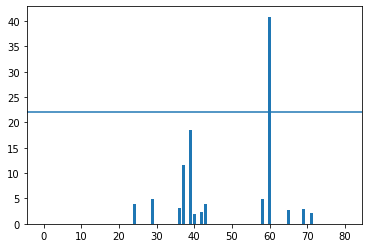

In [201]:
thisf=F.reshape(X.shape[:2]+(model2.J,))[89,49-5]
plt.bar(range(model2.J),thisf)
plt.axhline(THRESH)
np.where(thisf>THRESH)

In [192]:
allpeaks

[array([60., 89., 44.]),
 array([60., 83., 57.]),
 array([60., 76., 29.]),
 array([60., 74., 41.]),
 array([60., 69., 71.]),
 array([60., 65., 37.]),
 array([60., 60., 42.]),
 array([60., 58., 69.]),
 array([60., 37., 72.]),
 array([60., 35., 48.]),
 array([60., 34., 54.]),
 array([60., 31., 41.])]

In [128]:
peaks

array([[23., 73., 17.],
       [23., 70., 57.],
       [23., 50., 66.],
       [23., 38., 77.]])

# learn stuff

In [ ]:
barcoderegression.parameters.Barcode

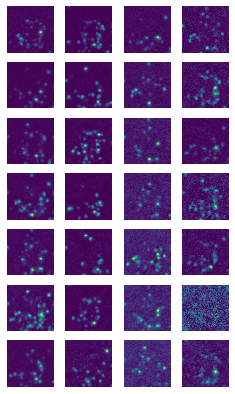

In [16]:

nby4(data)

In [9]:
data.shape

(7, 4, 100, 100)